<a href="https://colab.research.google.com/github/ejnaik/ejnaik/blob/main/ES670_Assignment_A_Vectors_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [65]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading all the required libraries


# Importing all the required libraries
import os
import numpy as np
import pandas as pd
import re
import cv2
import string
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    plt.clf()

## Q1: Searching Poems [5 Marks]

Given a list of poems we have created a database. Your job is to create a search engine for poems. A pre-defined list of poem strangas are given for those you have to find best matching poem.

### Base Code

In [67]:
def reconstruct_poem(poem_db, match_id):
    matched_poem = poem_db[match_id]
    freq_table, position_table = matched_poem
    max_idx = 0

    for idx_lst in position_table.values():
        max_idx = max(np.max(idx_lst), max_idx)

    poem_text = ['']*(max_idx+1)

    for key, value in position_table.items():
        for word_idx in value:
            poem_text[word_idx] = key

    return ' '.join(poem_text)

In [68]:
def create_lookup_table(text_data):
    poem_data = {}
    for poem_id, text in enumerate(text_data):
        freq_dict = {}
        position_dict = {}
        text = text.split()
        for idx, word in enumerate(text):
            if word in freq_dict:
                freq_dict[word] += 1
                position_dict[word].append(idx)
            else:
                freq_dict[word] = 1
                position_dict[word] = [idx]
        poem_data[f'poem_{poem_id}'] = [freq_dict, position_dict]
    return poem_data

In [69]:
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    return text

### Write Your Code

In [72]:
def search_poem(poem_db, poem_text):
    matched_poem_idx = 'poem_0' # deafult

    unique_words = set()
    for poem_id in poem_db.keys():
        freq_dict, position_dict = poem_db[poem_id]
        unique_words.update(freq_dict.keys())

    def get_vector(freq_dict):
        vector = []
        for word in unique_words:
            if word in freq_dict:
                vector.append(freq_dict[word])
            else:
                vector.append(0)
        return vector

    def cosine_sim(v1, v2):

        dot_product = np.dot(v1, v2)
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)

        return dot_product/(norm_v1*norm_v2)

    poem_text = clean_text(poem_text)
    freq_dict = {}

    text = poem_text.split()
    for idx, word in enumerate(text):
        if word in freq_dict:
            freq_dict[word] += 1
        else:
            freq_dict[word] = 1


    text_vector = get_vector(freq_dict)
    poems_vector = {}
    for poem_id in poem_db.keys():
        freq_dict_poem, position_dict_poem = poem_db[poem_id]
        freq_vector_poem = get_vector(freq_dict_poem)
        poems_vector[poem_id] = cosine_sim(text_vector, freq_vector_poem)

    matched_poem_idx = max(poems_vector, key=poems_vector.get)
    return matched_poem_idx

In [73]:
text_data = pd.read_csv('/content/drive/My Drive/ES670MM/dataset/A/preprocessed_data.csv', header=0)['text']
text_data = text_data.to_numpy()
print(f'Total poems: {text_data.shape}')

text_data = np.array([clean_text(text) for text in text_data])

Total poems: (70,)


In [74]:
poem_db = create_lookup_table(text_data)

In [75]:
search_lst = [
                'i am a business man i am a methodical man method is the thing after all but there are no people',
                'as it is well known that the  wise men  came  from the east  and as mr touchandgo bullethead came from the east it follows that mr bullethead',
                'as mere mathematician he could not have reasoned at all and thus would have been at the mercy of the prefect',
                'i had no desire to oppose what i regarded as at best but a harmless and by no means an unnatural precaution     at the request of usher i personally aided him in the arrangements for the temporary entombment the body having'
             ]

In [76]:
for search_item in search_lst:
    matched_poem_idx = search_poem(poem_db, search_item)
    search_result = reconstruct_poem(poem_db, matched_poem_idx)
    print('='*10)
    print(f'For search text: {search_item}')
    print('Found poem: ')
    print(search_result)
    print('='*10)

For search text: i am a business man i am a methodical man method is the thing after all but there are no people
Found poem: 
true nervous very very dreadfully nervous i had been and am but why will you say that i am mad the disease had sharpened my senses not destroyed not dulled them above all was the sense of hearing acute i heard all things in the heaven and in the earth i heard many things in hell how then am i mad hearken and observe how healthily how calmly i can tell you the whole story it is impossible to say how first the idea entered my brain but once conceived it haunted me day and night object there was none passion there was none i loved the old man he had never wronged me he had never given me insult for his gold i had no desire i think it was his eye yes it was this he had the eye of a vulture a pale blue eye with a film over it whenever it fell upon me my blood ran cold and so by degrees very gradually i made up my mind to take the life of the old man and thus rid myse

## Q2: Searching Photos [5 Marks]

The citizen of MatrixNagri are foodie people and also food vlogger. Wherever they go for eating they click pictures of the food. Your job is to cluster similar kind of food together with knowledge of cosine similairty. <br/>
Given mean images of 11 food classes, you have to assign the list of images to one of those classes.

### Loading the mean and search images

In [82]:
# Loading all the images in the drive
mean_images = []
mean_img_classes = []
search_images = []
search_img_classes = []

for files in tqdm(natsorted(glob('/content/drive/My Drive/ES670MM/dataset/A/images/mean_images/*'))):
    mean_images.append(cv2.imread(files, 1))
    mean_img_classes.append(os.path.splitext(os.path.basename(files))[0])

for files in tqdm(natsorted(glob('/content/drive/My Drive/ES670MM/dataset/A/images/search_images/*'))):
    search_images.append(cv2.imread(files, 1))
    search_img_classes.append(os.path.splitext(os.path.basename(files))[0].split('_')[0])

mean_images = np.array(mean_images) # Only possible because all images are of same size
search_images = np.array(search_images)

100%|██████████| 110/110 [00:00<00:00, 122.15it/s]


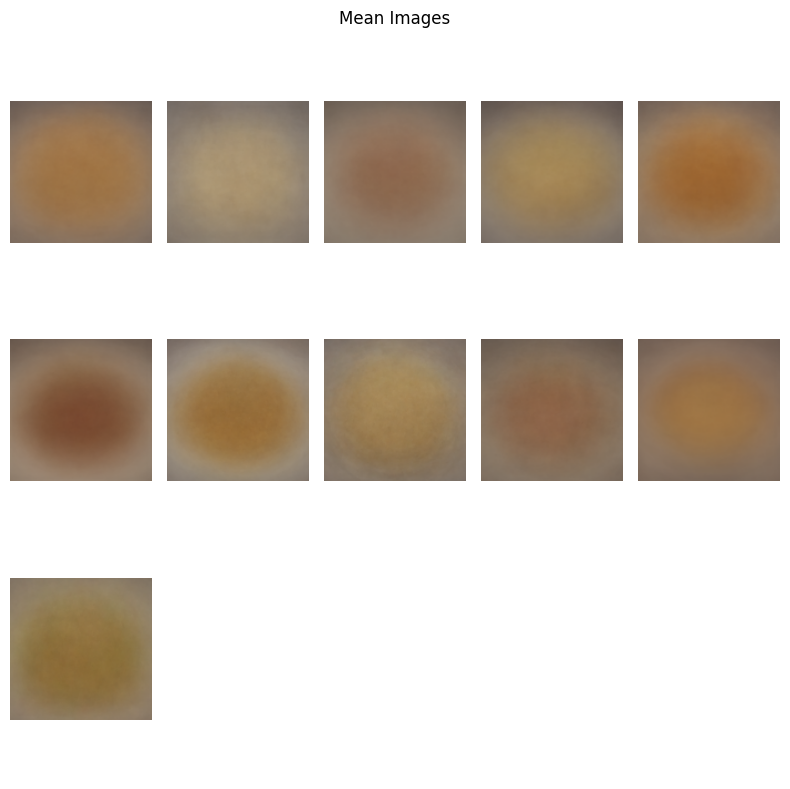

<Figure size 640x480 with 0 Axes>

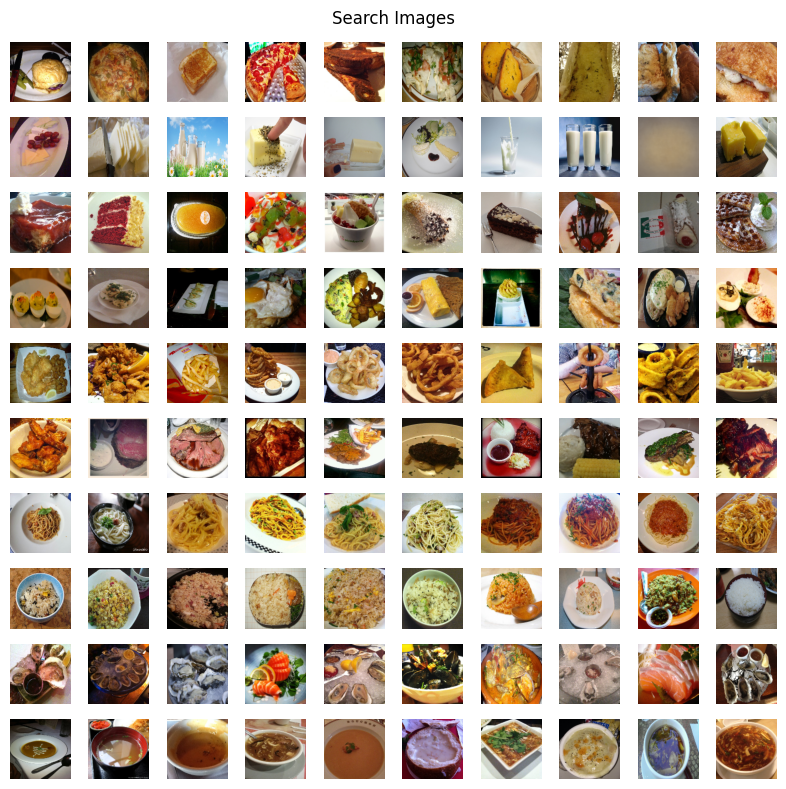

<Figure size 640x480 with 0 Axes>

In [83]:
show_image_grid(mean_images, 3, 5, 'Mean Images', figsize=8)
show_image_grid(search_images, 10, 10, 'Search Images', figsize=8)

In [84]:
def image_lookup_fn(mean_images, query_image, mean_img_classes):
    best_match_idx = np.random.randint(0, 10) # default

    # Write your code here
    # You have to search among mean_images which one is closest to the query image
    # return the class of mean image which has the highest matching score

    def cosine_sim(image1, image2):

      vec1 = np.array(image1).flatten().reshape(1, -1)
      vec2 = np.array(image2).flatten().reshape(1, -1)

      dot_product = np.dot(vec1, vec2.T)
      norm_v1 = np.linalg.norm(vec1)
      norm_v2 = np.linalg.norm(vec2)

      return dot_product/(norm_v1*norm_v2)

    similarity = {}
    for idx, mean_image in enumerate(mean_images):

      similarity[idx] = cosine_sim(mean_image, query_image)

    best_match_idx = max(similarity, key=similarity.get)

    return mean_img_classes[best_match_idx]

100%|██████████| 110/110 [00:00<00:00, 445.81it/s]


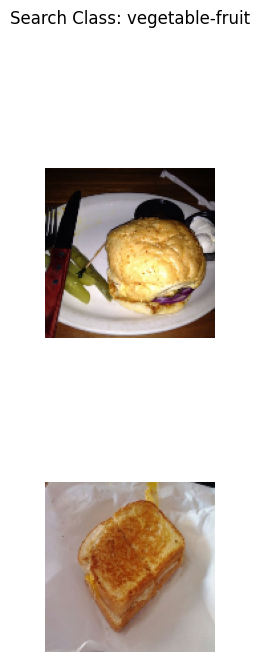

<Figure size 640x480 with 0 Axes>

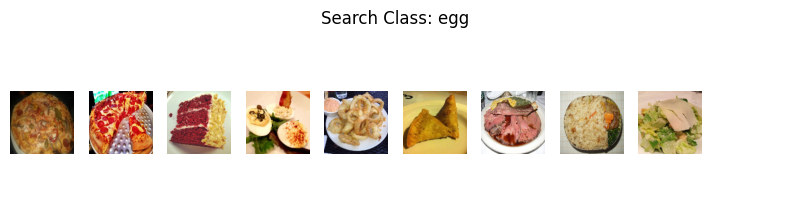

<Figure size 640x480 with 0 Axes>

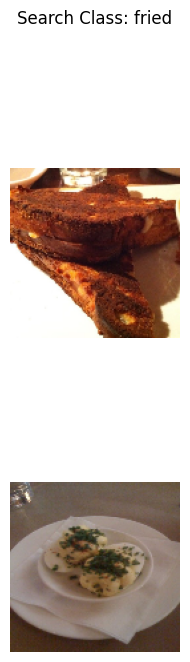

<Figure size 640x480 with 0 Axes>

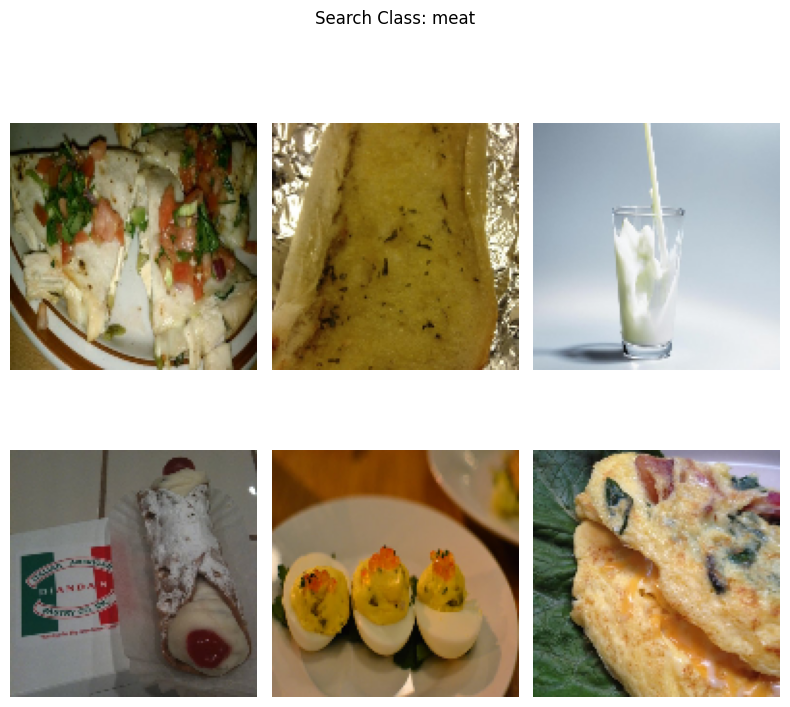

<Figure size 640x480 with 0 Axes>

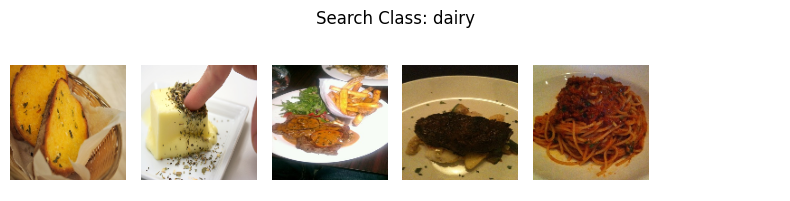

<Figure size 640x480 with 0 Axes>

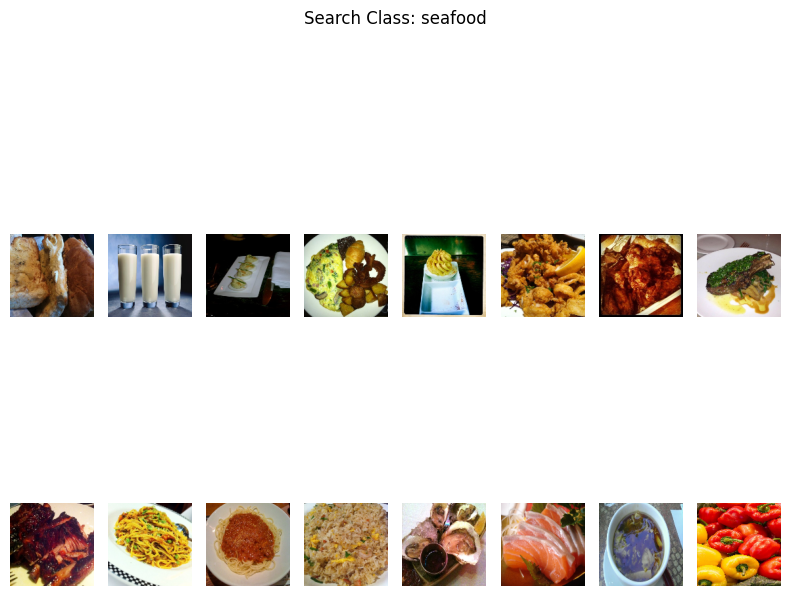

<Figure size 640x480 with 0 Axes>

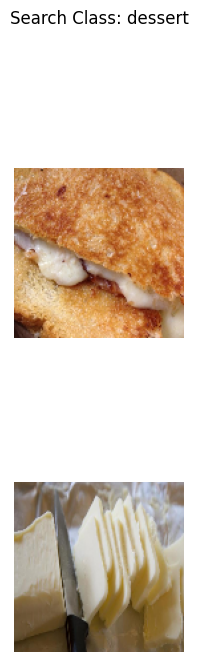

<Figure size 640x480 with 0 Axes>

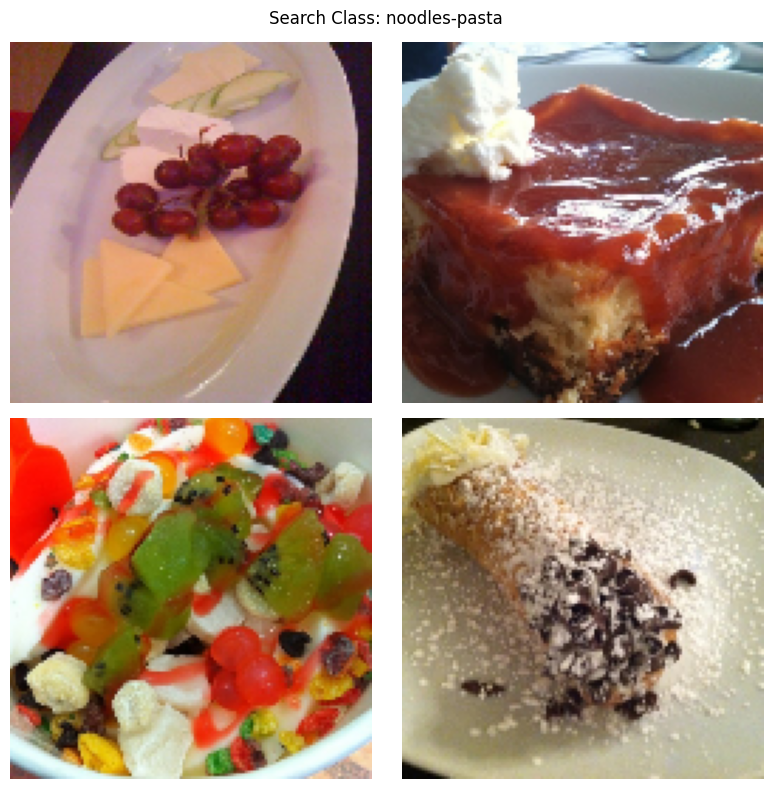

<Figure size 640x480 with 0 Axes>

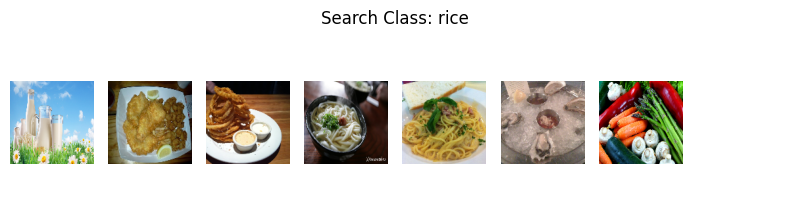

<Figure size 640x480 with 0 Axes>

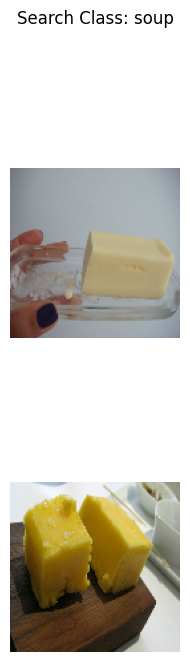

<Figure size 640x480 with 0 Axes>

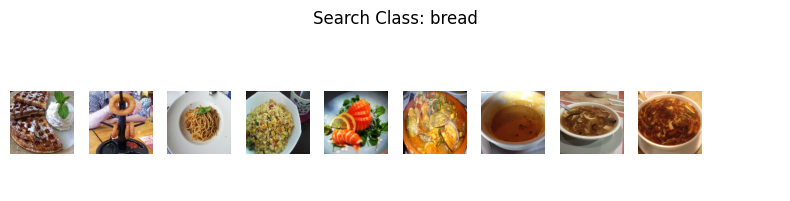

<Figure size 640x480 with 0 Axes>

In [85]:
pred_classes = []
cluster_images = {}

for query_image in tqdm(search_images):
    pred_classes.append(image_lookup_fn(mean_images, query_image, mean_img_classes))
    if pred_classes[-1] in cluster_images:
        cluster_images[pred_classes[-1]].append(query_image)
    else:
        cluster_images[pred_classes[-1]] = [query_image]

for class_name, img_lst in cluster_images.items():
    img_lst = np.array(img_lst)
    M = img_lst.shape[0]//10 + 1
    N = img_lst.shape[0]%10 + 1
    show_image_grid(img_lst, M, N, f'Search Class: {class_name}', figsize=8)

In [81]:
# Calculate the accruacy (pred_classes, search_img_classes)

## References

1. [Poem Dataset](https://www.kaggle.com/datasets/leangab/poe-short-stories-corpuscsv)